# Capstone Project - The Battle of Neighborhoods (Week 2)


### Importing all libraries

Downloading all the dependencies needed

In [1]:
import numpy as np  # useful for many scientific computing in Python / library to handle data in a vectorized manner
import pandas as pd # primary data structure library
from bs4 import BeautifulSoup #  website scraping libraries and packages in Python
import requests # library to handle requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

from PIL import Image # converting images into arrays

print ('Wordcloud is installed and imported!')

print('Libraries imported.')


Wordcloud is installed and imported!
Libraries imported.


## Assigning the link of the website

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
website_url = requests.get(url).text

In [3]:
soup = BeautifulSoup(website_url,'lxml')

## 1. Data preparation 

In [4]:
# Data extracted from Wikipedia
# define the dataframe columns
column_names = ['Postcode', 'Borough', 'Neighbourhood']
toronto_list = []
for tr in soup.tbody.find_all('tr'):
    toronto_list.append([ td.get_text().strip() for td in tr.find_all('td')])
data = pd.DataFrame(toronto_list)
data.columns= column_names

# Dropping Not assigned borough.
data.drop(data[data['Borough'] == 'Not assigned'].index, inplace=True)
sum(data['Borough'] == 'Not assigned')

# Signing the Borouh name to the "Not assigned" Neighborhood
data.loc[data.Neighbourhood == 'Not assigned', "Neighbourhood"] = data.Borough
sum(data['Neighbourhood'] == 'Not assigned')

# Combining neibourhoods that have same postcode
df = data.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
df.shape

(103, 3)

### Get the neighborhood's latitude and longitude values.

In [6]:
# Read data from CSV file
url_coord = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(url_coord)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
# Changing the column name of the dataframe
df_coordinates.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
df_coordinates.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# Merge both datasets
df_neigh_coord = pd.merge(df, df_coordinates, on='Postcode')
df_neigh_coord.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Getting the neiborhood profiles of Toronto

In [9]:
# Read data from CSV file
df_neigh_profiles = pd.read_csv('https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv', encoding='latin1')
df_neigh_profiles.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No Designat

In [10]:
df_neigh_profiles.shape

(2383, 145)

In [11]:
#Extracting the neighborhoods into a new dataset including the population, income and age demography
toronto_neigh = list(df_neigh_profiles.columns.values)
toronto_neigh = toronto_neigh[5:]

dftoronto_neigh = pd.DataFrame(index=toronto_neigh, columns=
                               ["Population_2016",
                                "Income_2016", 
                                "Children_0-14_years", 
                                "Youth_15-24_years", 
                                "Working_Age_25-54_years", 
                                "Pre-retirement_55-64_years", 
                                "Seniors_65+_years", 
                                "Older_Seniors_85+_years",])

# Population_2016 = Population, 2016
# Income_2016 = Total income: Average amount ($)
# Children (0-14 years)
# Youth (15-24 years)
# Working Age (25-54 years)
# Pre-retirement (55-64 years)
# Seniors (65+ years)
# Older Seniors (85+ years)


for index, row in dftoronto_neigh.iterrows():
    dftoronto_neigh.at[index, 'Population_2016'] = df_neigh_profiles[index][2]
    dftoronto_neigh.at[index, 'Income_2016'] = df_neigh_profiles[index][2264]
    dftoronto_neigh.at[index, 'Children_0-14_years'] = df_neigh_profiles[index][9]
    dftoronto_neigh.at[index, 'Youth_15-24_years'] = df_neigh_profiles[index][10]
    dftoronto_neigh.at[index, 'Working_Age_25-54_years'] = df_neigh_profiles[index][11]
    dftoronto_neigh.at[index, 'Pre-retirement_55-64_years'] = df_neigh_profiles[index][12]
    dftoronto_neigh.at[index, 'Seniors_65+_years'] = df_neigh_profiles[index][13]
    dftoronto_neigh.at[index, 'Older_Seniors_85+_years'] = df_neigh_profiles[index][14]
    
dftoronto_neigh.head()

,Population_2016,Income_2016,Children_0-14_years,Youth_15-24_years,Working_Age_25-54_years,Pre-retirement_55-64_years,Seniors_65+_years,Older_Seniors_85+_years
Agincourt North,"29,113","30,414","3,840","3,705","11,305","4,230","6,045",925
Agincourt South-Malvern West,"23,757","31,825","3,075","3,360","9,965","3,265","4,105",555
Alderwood,"12,054","47,709","1,760","1,235","5,220","1,825","2,015",320
Annex,"30,526","112,766","2,360","3,750","15,040","3,480","5,910","1,040"
Banbury-Don Mills,"27,695","67,757","3,605","2,730","10,810","3,555","6,975","1,640"


In [12]:
#Formatting data
cols = ["Population_2016", "Income_2016", "Children_0-14_years", "Youth_15-24_years", "Working_Age_25-54_years","Pre-retirement_55-64_years", "Seniors_65+_years", "Older_Seniors_85+_years"]
dftoronto_neigh[cols] = dftoronto_neigh[cols].replace({',': ''}, regex=True)
dftoronto_neigh.head()

,Population_2016,Income_2016,Children_0-14_years,Youth_15-24_years,Working_Age_25-54_years,Pre-retirement_55-64_years,Seniors_65+_years,Older_Seniors_85+_years
Agincourt North,29113,30414,3840,3705,11305,4230,6045,925
Agincourt South-Malvern West,23757,31825,3075,3360,9965,3265,4105,555
Alderwood,12054,47709,1760,1235,5220,1825,2015,320
Annex,30526,112766,2360,3750,15040,3480,5910,1040
Banbury-Don Mills,27695,67757,3605,2730,10810,3555,6975,1640


In [13]:
dftoronto_neigh[cols] = dftoronto_neigh[cols].astype(float)
dftoronto_neigh.dtypes

Population_2016               float64
Income_2016                   float64
Children_0-14_years           float64
Youth_15-24_years             float64
Working_Age_25-54_years       float64
Pre-retirement_55-64_years    float64
Seniors_65+_years             float64
Older_Seniors_85+_years       float64
dtype: object

In [14]:
dftoronto_neigh.sort_values('Population_2016', ascending=False)

,Population_2016,Income_2016,Children_0-14_years,Youth_15-24_years,Working_Age_25-54_years,Pre-retirement_55-64_years,Seniors_65+_years,Older_Seniors_85+_years
Waterfront Communities-The Island,65913.0,70600.0,3650.0,7840.0,45105.0,4680.0,4635.0,365.0
Woburn,53485.0,30878.0,9625.0,7660.0,21945.0,6245.0,8010.0,1130.0
Willowdale East,50434.0,45326.0,5920.0,6940.0,25850.0,5460.0,6270.0,830.0
Rouge,46496.0,39556.0,7960.0,6700.0,18510.0,6690.0,6625.0,685.0
L'Amoreaux,43993.0,31826.0,6120.0,5730.0,17210.0,5930.0,8990.0,1345.0
Islington-City Centre West,43965.0,52787.0,5820.0,4695.0,20640.0,5400.0,7405.0,1480.0
Malvern,43794.0,29573.0,7910.0,6620.0,17865.0,5535.0,5890.0,445.0
Dovercourt-Wallace Emerson-Junction,36625.0,39740.0,4480.0,3925.0,19790.0,3935.0,4515.0,595.0
Downsview-Roding-CFB,35052.0,34168.0,5725.0,4340.0,15045.0,4380.0,5535.0,870.0
Parkwoods-Donalda,34805.0,42516.0,5840.0,4680.0,14780.0,4265.0,5250.0,775.0


In [15]:
df_TOP5_toronto_neigh = dftoronto_neigh.sort_values('Population_2016', ascending=False).head()
df_TOP5_toronto_neigh.drop(df_TOP5_toronto_neigh.columns[[0,1]], axis=1,inplace=True)
df_TOP5_toronto_neigh

,Children_0-14_years,Youth_15-24_years,Working_Age_25-54_years,Pre-retirement_55-64_years,Seniors_65+_years,Older_Seniors_85+_years
Waterfront Communities-The Island,3650.0,7840.0,45105.0,4680.0,4635.0,365.0
Woburn,9625.0,7660.0,21945.0,6245.0,8010.0,1130.0
Willowdale East,5920.0,6940.0,25850.0,5460.0,6270.0,830.0
Rouge,7960.0,6700.0,18510.0,6690.0,6625.0,685.0
L'Amoreaux,6120.0,5730.0,17210.0,5930.0,8990.0,1345.0


Text(0.5, 1.0, 'Toronto Population by Age')

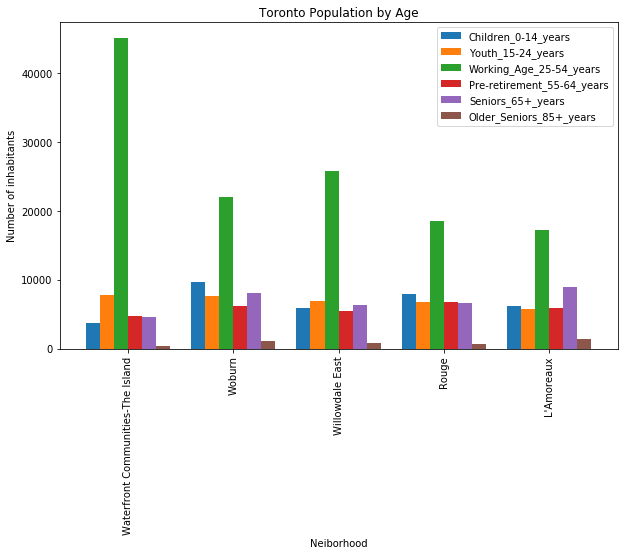

In [16]:
df_TOP5_toronto_neigh.plot(kind='bar', figsize=(10, 6), width=0.8) 

plt.xlabel('Neiborhood')
plt.ylabel('Number of inhabitants')
plt.title('Toronto Population by Age')


####  Getting the geographical coordinates of Toronto.

In [17]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


## 2. Explore Neighborhoods in Toronto

In [18]:
# creatting a map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

df_neigh_coord.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neigh_coord['Latitude'],
                                           df_neigh_coord['Longitude'],
                                           df_neigh_coord['Borough'],
                                           df_neigh_coord['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [19]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'QD1A3EQKL2155XRNC3TIMTB00YYG2GPDMXJLKVVQDMKY4KUI' # your Foursquare ID
CLIENT_SECRET = '1DP5Y55VMWYIQJHOD23L3YIQJC0ZHZKX0QC1NHLGLNZCP2HI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QD1A3EQKL2155XRNC3TIMTB00YYG2GPDMXJLKVVQDMKY4KUI
CLIENT_SECRET:1DP5Y55VMWYIQJHOD23L3YIQJC0ZHZKX0QC1NHLGLNZCP2HI


### Getting information from venues on each neighborhood

Writing a code to run a function that gets the information from venues on each neighborhood and include into a new dataframe. 
I am getting the top 100 venues that are in the neighborhoods within a radius of 500 meters.


In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
venue_id = '4d4b7105d754a06374d81259' ## Limit of number of venues by top level Food ID

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            venue_id)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [21]:
toronto_venues = getNearbyVenues(names=df_neigh_coord['Neighborhood'],
                                   latitudes=df_neigh_coord['Latitude'],
                                   longitudes=df_neigh_coord['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [22]:
# checking the size of the resulting dataframe
print(toronto_venues.shape)
toronto_venues.to_csv('toronto_Restaurants_venues')
toronto_venues.head()

(1671, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian Restaurant
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Doug's Bakery,43.762400,-79.192285,Bakery
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


In [23]:
# Checking how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",96,96,96,96,96,96
Agincourt,3,3,3,3,3,3
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",1,1,1,1,1,1
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",6,6,6,6,6,6
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Downsview North, Wilson Heights",9,9,9,9,9,9
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",21,21,21,21,21,21
Berczy Park,49,49,49,49,49,49


#### Let's find out how many unique categories can be curated from all the returned venues

In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 92 uniques categories.


## 3. Analyze Each Neighborhood

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# examining the new dataframe size.
toronto_onehot.shape

(1671, 93)

### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.052083,0.000000,0.041667,0.000000,0.010417,0.031250,0.000000,0.000000,0.010417,0.031250,0.041667,0.020833,0.000000,0.072917,0.0000,0.000000,0.010417,0.010417,0.000000,0.000000,0.000000,0.041667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010417,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.020833,0.000000,0.010417,0.010417,0.0,0.000000,0.000000,0.010417,0.00,0.000000,0.031250,0.031250,0.000000,0.000000,0.010417,0.000000,0.000000,0.010417,0.020833,0.010417,0.010417,0.000000,0.000000,0.010417,0.010417,0.000000,0.000000,0.020833,0.010417,0.000000,0.000000,0.010417,0.000000,0.072917,0.052083,0.072917,0.020833,0.000000,0.010417,0.000000,0.000000,0.000000,0.041667,0.020833,0.000000,0.000000,0.000000,0.041667,0.000000,0.020833,0.000000,0.000000
1,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [28]:
# confirming the new size
toronto_grouped.shape

(92, 93)

#### Printing each neighborhood along with the top 10 most common venues

In [29]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0       Sandwich Place  0.07
1                 Café  0.07
2           Restaurant  0.07
3          Salad Place  0.05
4  American Restaurant  0.05
5      Thai Restaurant  0.04
6        Deli / Bodega  0.04
7         Burger Joint  0.04
8           Steakhouse  0.04
9     Asian Restaurant  0.04


----Agincourt----
                       venue  freq
0             Sandwich Place  0.33
1         Chinese Restaurant  0.33
2             Breakfast Spot  0.33
3          Afghan Restaurant  0.00
4  Middle Eastern Restaurant  0.00
5                Pizza Place  0.00
6         Persian Restaurant  0.00
7     Peking Duck Restaurant  0.00
8               Noodle House  0.00
9    New American Restaurant  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                             venue  freq
0                 Asian Restaurant   1.0
1                Afghan Restaurant   0.0
2               Mexican Restaurant   0.0
3           

                       venue  freq
0                     Bakery  0.50
1          Indian Restaurant  0.25
2                 Restaurant  0.25
3  Middle Eastern Restaurant  0.00
4                Pizza Place  0.00
5         Persian Restaurant  0.00
6     Peking Duck Restaurant  0.00
7               Noodle House  0.00
8    New American Restaurant  0.00
9        Moroccan Restaurant  0.00


----Clarks Corners, Sullivan, Tam O'Shanter----
                        venue  freq
0                 Pizza Place  0.25
1          Italian Restaurant  0.12
2             Thai Restaurant  0.12
3                Noodle House  0.12
4         Fried Chicken Joint  0.12
5          Chinese Restaurant  0.12
6        Fast Food Restaurant  0.12
7  Modern European Restaurant  0.00
8          Persian Restaurant  0.00
9      Peking Duck Restaurant  0.00


----Cliffcrest, Cliffside, Scarborough Village West----
                             venue  freq
0              American Restaurant   1.0
1                Afghan Resta

                       venue  freq
0                Pizza Place   0.2
1                 Restaurant   0.2
2                     Bakery   0.2
3             Breakfast Spot   0.2
4         Mexican Restaurant   0.2
5          Afghan Restaurant   0.0
6  Middle Eastern Restaurant   0.0
7         Persian Restaurant   0.0
8     Peking Duck Restaurant   0.0
9               Noodle House   0.0


----Harbord, University of Toronto----
                     venue  freq
0                     Café  0.29
1               Restaurant  0.11
2           Sandwich Place  0.11
3                   Bakery  0.07
4       Italian Restaurant  0.07
5      Japanese Restaurant  0.07
6  Comfort Food Restaurant  0.04
7            Poutine Place  0.04
8             Noodle House  0.04
9         Sushi Restaurant  0.04


----Harbourfront East, Toronto Islands, Union Station----
                  venue  freq
0            Restaurant  0.12
1                  Café  0.08
2           Pizza Place  0.08
3  Fast Food Restaurant  0.07
4

                             venue  freq
0                   Breakfast Spot  0.25
1               Italian Restaurant  0.12
2      Eastern European Restaurant  0.12
3                      Pizza Place  0.12
4                    Deli / Bodega  0.12
5                 Cuban Restaurant  0.12
6                       Restaurant  0.12
7                Afghan Restaurant  0.00
8  Molecular Gastronomy Restaurant  0.00
9               Persian Restaurant  0.00


----Parkwoods----
                       venue  freq
0                  BBQ Joint   0.5
1       Fast Food Restaurant   0.5
2          Afghan Restaurant   0.0
3  Middle Eastern Restaurant   0.0
4                Pizza Place   0.0
5         Persian Restaurant   0.0
6     Peking Duck Restaurant   0.0
7               Noodle House   0.0
8    New American Restaurant   0.0
9        Moroccan Restaurant   0.0


----Queen's Park----
                   venue  freq
0       Sushi Restaurant  0.10
1    Japanese Restaurant  0.07
2                  Diner  0.

                             venue  freq
0                      Pizza Place  0.67
1                           Bakery  0.33
2                Afghan Restaurant  0.00
3               Mexican Restaurant  0.00
4               Persian Restaurant  0.00
5           Peking Duck Restaurant  0.00
6                     Noodle House  0.00
7          New American Restaurant  0.00
8              Moroccan Restaurant  0.00
9  Molecular Gastronomy Restaurant  0.00


----Woburn----
                             venue  freq
0                Indian Restaurant  0.33
1               Mexican Restaurant  0.33
2                Korean Restaurant  0.33
3                      Pizza Place  0.00
4               Persian Restaurant  0.00
5           Peking Duck Restaurant  0.00
6                     Noodle House  0.00
7          New American Restaurant  0.00
8              Moroccan Restaurant  0.00
9  Molecular Gastronomy Restaurant  0.00


----Woodbine Gardens, Parkview Hill----
                     venue  freq
0     

#### Putting that into a pandas dataframe

In [30]:
# write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Café,Restaurant,Sandwich Place,American Restaurant,Salad Place,Steakhouse,Burger Joint,Deli / Bodega,Asian Restaurant,Thai Restaurant
1,Agincourt,Chinese Restaurant,Sandwich Place,Breakfast Spot,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Asian Restaurant,Wings Joint,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Japanese Restaurant,Sandwich Place,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
4,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Burger Joint,German Restaurant,Gastropub,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant


## 4. Cluster Neighborhoods

#### Runnig k-means to cluster the neighborhood into 5 clusters.

In [32]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([2, 2, 2, 2, 1, 2, 2, 2, 2, 1])

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neigh_coord

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')

toronto_merged.head() # check the last columns!


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,4,Indian Restaurant,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2,Pizza Place,Bakery,Restaurant,Mexican Restaurant,Breakfast Spot,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bakery,Caribbean Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1,Pizza Place,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant


#### Visualizing the resulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## 5. Examine Clusters

### Cluster 1

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Scarborough,0,American Restaurant,Wings Joint,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
68,Downtown Toronto,0,American Restaurant,Tapas Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


### Cluster 2

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,1,Pizza Place,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
9,Scarborough,1,Pizza Place,Café,Wings Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
24,North York,1,Pizza Place,Bakery,Wings Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
40,East York,1,Greek Restaurant,Pizza Place,Gluten-free Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
72,North York,1,Pizza Place,Asian Restaurant,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
81,York,1,Caribbean Restaurant,Pizza Place,Wings Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
89,Etobicoke,1,Pizza Place,Sandwich Place,Burger Joint,German Restaurant,Gastropub,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
93,Etobicoke,1,Pizza Place,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
99,Etobicoke,1,Pizza Place,Chinese Restaurant,Sandwich Place,Middle Eastern Restaurant,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
100,Etobicoke,1,Pizza Place,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant


### Cluster 3

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,2,Pizza Place,Bakery,Restaurant,Mexican Restaurant,Breakfast Spot,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
3,Scarborough,2,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,Scarborough,2,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bakery,Caribbean Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant
6,Scarborough,2,Chinese Restaurant,Bakery,Food Truck,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
7,Scarborough,2,Bakery,Indian Restaurant,Restaurant,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
10,Scarborough,2,Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Latin American Restaurant,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
11,Scarborough,2,Middle Eastern Restaurant,Bakery,Sandwich Place,Breakfast Spot,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
12,Scarborough,2,Chinese Restaurant,Sandwich Place,Breakfast Spot,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
13,Scarborough,2,Pizza Place,Noodle House,Thai Restaurant,Fried Chicken Joint,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Diner,Doner Restaurant
14,Scarborough,2,Asian Restaurant,Wings Joint,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant


### Cluster 4

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,3,Dim Sum Restaurant,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant


### Cluster 5

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,4,Indian Restaurant,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
17,North York,4,Mediterranean Restaurant,Fast Food Restaurant,Wings Joint,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
25,North York,4,BBQ Joint,Fast Food Restaurant,Wings Joint,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
74,York,4,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
80,York,4,Fast Food Restaurant,Fried Chicken Joint,Restaurant,Sandwich Place,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
87,East Toronto,4,Fast Food Restaurant,Burrito Place,Restaurant,Pizza Place,Gastropub,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


### Creating a Dataframe with the cluster 3 

In [40]:
df_venues = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_venues.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,2,Pizza Place,Bakery,Restaurant,Mexican Restaurant,Breakfast Spot,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
3,Scarborough,2,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,Scarborough,2,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bakery,Caribbean Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant
6,Scarborough,2,Chinese Restaurant,Bakery,Food Truck,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
7,Scarborough,2,Bakery,Indian Restaurant,Restaurant,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


### Let's visualize the most frequent results by using a word cloud

In [41]:
restaurant_list = df_venues
restaurant_list.drop(restaurant_list.columns[[0,1]], axis=1,inplace=True)
restaurant_list = restaurant_list.reset_index(drop=True)
restaurant_list.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pizza Place,Bakery,Restaurant,Mexican Restaurant,Breakfast Spot,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bakery,Caribbean Restaurant,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant
3,Chinese Restaurant,Bakery,Food Truck,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,Bakery,Indian Restaurant,Restaurant,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


In [42]:
#Converting the data into text
restaurant_list.to_csv(r'restaurant_text.txt', header=None, index=None, sep=' ', mode='a')

In [43]:
# open the file and read it into a variable
restaurant_txt = open('restaurant_text.txt', 'r').read()

In [44]:
stopwords = set(STOPWORDS)

In [45]:
# save mask to 
restaurant_mask = np.array(Image.open('Torontomap_mask.png'))

# instantiate a word cloud object
restaurant_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
restaurant_wc.generate(restaurant_txt)

#### Shaping the word cloud according to the mask that that is the map of Toronto.

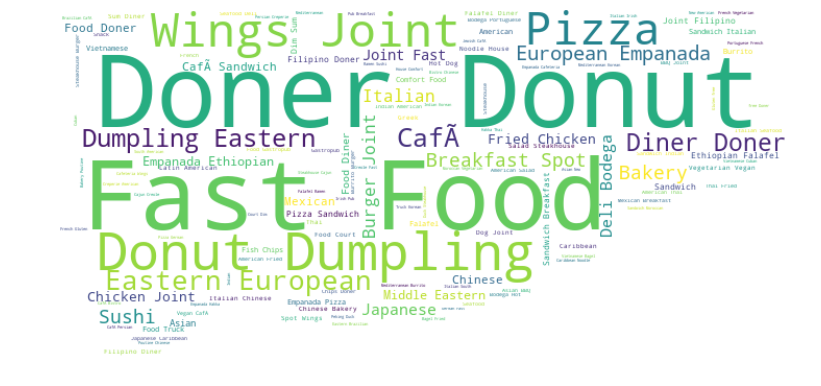

In [52]:
stopwords.add('Shop')
stopwords.add('Place')
stopwords.add('Restaurant')
# instantiate a word cloud object
restaurant_wc = WordCloud(background_color='white', max_words=2000, mask=restaurant_mask, stopwords=stopwords)

# generate the word cloud
restaurant_wc.generate(restaurant_txt)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(restaurant_wc, interpolation='bilinear')
plt.axis('off')
plt.show()